# Pfizer Vaccine Tweet Dataset

Tweet dataset ini digunakan untuk mengetahui atau menentukan sentimen yang ada dari tweet yang ada didalamnya. metode yaang digunakan adalah NLP atau Neuro-Linguistic Programming dimana akan dilakukan beberapa perubahan pada tweet dengan melakukan preprocessing untuk mendapat sentiment yang dianggap baik. dataset dapat diuunduh pada link yang tersedia [download di sini]('https://www.kaggle.com/gpreda/pfizer-vaccine-tweets?select=vaccination_tweets.csv')

# Import Library

In [314]:
# import library yang digunakan dan beberapa library di import sesuai kebutuhan
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stopwords_en = stopwords.words('english')
stemmer = SnowballStemmer("english")
lemma = nltk.wordnet.WordNetLemmatizer()

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [315]:
# loading dataset
tweet_df = pd.read_csv('/content/vaccination_tweets.csv')
tweet_df = tweet_df[['date','text']]
tweet_df = tweet_df.rename(columns={'text':'tweet'})
tweet_df.head(10)

,date,tweet
0,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...
1,2020-12-13 16:27:13,While the world has been on the wrong side of ...
2,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're..."
4,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...
5,2020-12-12 20:11:42,Does anyone have any useful advice/guidance fo...
6,2020-12-12 20:06:00,it is a bit sad to claim the fame for success ...
7,2020-12-12 20:04:29,There have not been many bright days in 2020 b...
8,2020-12-12 20:01:16,Covid vaccine; You getting it?\n\n #CovidVacci...
9,2020-12-12 19:30:33,#CovidVaccine \n\nStates will start getting #C...


In [316]:
# menampilkan row dan kolom
print('banyaknya baris :', tweet_df.shape[0])
print('banyaknya kolom :', tweet_df.shape[1])

banyaknya baris : 10305
banyaknya kolom : 2


In [317]:
# menampilkan info dataset
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10305 entries, 0 to 10304
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    10305 non-null  object
 1   tweet   10305 non-null  object
dtypes: object(2)
memory usage: 161.1+ KB


In [318]:
# menampilkan null value dataset
tweet_df.isna().sum()

date     0
tweet    0
dtype: int64

In [319]:
# menampilkan deskripsi 
tweet_df.describe()

,date,tweet
count,10305,10305
unique,10293,10298
top,2021-05-29 08:46:34,#Covid19 Vaccine Rollout Needs Spark Even More...
freq,2,5


> Dataset diatas menunjukan bahwa:
1. Dataset menunjukan bahwa banyaknya baris : 10305 dan banyaknya kolom : 2.
2. Baik date dan text tipe data merupakan object.
3. Tidak terdapat null value.
4. Pada kolom text terdapat frekuensi pengulangan terbanyak sebanyak 5 kali sehingga diasumsikan merupakan duplikasi text. 

# Preprocessing

In [320]:
# melihat duplikat text untuk ditentukan apa yang akan dilakukan setelahnya
data= tweet_df.copy()
print('banyaknya duplikat:',data.tweet.duplicated().sum())
data[data.tweet.duplicated() == True]
# menunjukan adanya duplikat pada kolom text

banyaknya duplikat: 7


,date,tweet
2790,2021-01-09 18:45:24,So yesterday was rough - fatigue headache and ...
2997,2021-01-10 06:20:02,#Dubai opens seventh clinic for Covid-19 #Pfiz...
4116,2021-01-21 20:24:47,#Covid19 Vaccine Rollout Needs Spark Even More...
4360,2021-01-22 16:00:00,Vaccinated and ready to dominate the world onc...
4499,2021-01-24 18:22:48,#Covid19 Vaccine Rollout Needs Spark Even More...
4531,2021-01-26 06:54:38,#Covid19 Vaccine Rollout Needs Spark Even More...
4594,2021-01-27 07:50:16,#Covid19 Vaccine Rollout Needs Spark Even More...


In [321]:
data.tweet[2]

'#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P'

In [322]:
# # drop data yang duplikat pada text
data = data.drop_duplicates(subset='tweet', keep='first').reset_index()

In [323]:
# dictionary yang digunakan untuk melakukan perbaikan frase

contractions_dict = { 
"ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have",
"couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","doesn’t": "does not",
"don't": "do not","don’t": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not","haven't": "have not",
"he'd": "he had","he'd've": "he would have","he'll": "he will","he'll've": "he will have","he's": "he is","how'd": "how did",
"how'd'y": "how do you","how'll": "how will","how's": "how is","i'd": "i would","i'd've": "i would have","i'll": "i will",
"i'll've": "i will have","i'm": "i am","i've": "i have","isn't": "is not","it'd": "it would","it'd've": "it would have",
"it'll": "it will","it'll've": "it will have","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not",
"might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not",
"mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
"shan't've": "shall not have","she'd": "she would","she'd've": "she would have","she'll": "she will","she'll've": "she will have",
"she's": "she is","should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so is","that'd": "that would","that'd've": "that would have",
"that's": "that is","there'd": "there would","there'd've": "there would have","there's": "there is","they'd": "they would",
"they'd've": "they would have","they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have",
"to've": "to have","wasn't": "was not","we'd": "we would","we'd've": "we would have","we'll": "we will","we'll've": "we will have",
"we're": "we are","we've": "we have","weren't": "were not","what'll": "what will","what'll've": "what will have","what're": "what are","what's": "what is",
"what've": "what have","when's": "when is","when've": "when have","where'd": "where did","where's": "where is",
"where've": "where have","who'll": "who will","who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is","why've": "why have","will've": "will have",
"won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not","wouldn't've": "would not have","y'all": "you all",
"y’all": "you all","y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
"you'd": "you would","you'd've": "you would have","you'll": "you will","you'll've": "you will have","you're": "you are","you've": "you have","ain’t": "am not","aren’t": "are not",
"can’t": "cannot","can’t’ve": "cannot have","’cause": "because","could’ve": "could have","couldn’t": "could not","couldn’t’ve": "could not have",
"didn’t": "did not","doesn’t": "does not","don’t": "do not","don’t": "do not","hadn’t": "had not","hadn’t’ve": "had not have","hasn’t": "has not","haven’t": "have not",
"he’d": "he had","he’d’ve": "he would have","he’ll": "he will","he’ll’ve": "he will have","he’s": "he is","how’d": "how did","how’d’y": "how do you","how’ll": "how will",
"how’s": "how is","i’d": "i would","i’d’ve": "i would have","i’ll": "i will","i’ll’ve": "i will have","i’m": "i am","i’ve": "i have","isn’t": "is not","it’d": "it would","it’d’ve": "it would have",
"it’ll": "it will","it’ll’ve": "it will have","it’s": "it is","let’s": "let us","ma’am": "madam","mayn’t": "may not","might’ve": "might have",
"mightn’t": "might not","mightn’t’ve": "might not have","must’ve": "must have","mustn’t": "must not","mustn’t’ve": "must not have","needn’t": "need not",
"needn’t’ve": "need not have","o’clock": "of the clock","oughtn’t": "ought not","oughtn’t’ve": "ought not have","shan’t": "shall not","sha’n’t": "shall not","shan’t’ve": "shall not have",
"she’d": "she would","she’d’ve": "she would have","she’ll": "she will","she’ll’ve": "she will have","she’s": "she is","should’ve": "should have",
"shouldn’t": "should not","shouldn’t’ve": "should not have","so’ve": "so have","so’s": "so is","that’d": "that would","that’d’ve": "that would have",
"that’s": "that is","there’d": "there would","there’d’ve": "there would have","there’s": "there is","they’d": "they would","they’d’ve": "they would have","they’ll": "they will",
"they’ll’ve": "they will have","they’re": "they are","they’ve": "they have","to’ve": "to have","wasn’t": "was not","we’d": "we would","we’d’ve": "we would have","we’ll": "we will",
"we’ll’ve": "we will have","we’re": "we are","we’ve": "we have","weren’t": "were not","what’ll": "what will","what’ll’ve": "what will have",
"what’re": "what are","what’s": "what is","what’ve": "what have","when’s": "when is","when’ve": "when have","where’d": "where did","where’s": "where is",
"where’ve": "where have","who’ll": "who will","who’ll’ve": "who will have","who’s": "who is","who’ve": "who have","why’s": "why is","why’ve": "why have","will’ve": "will have",
"won’t": "will not","won’t’ve": "will not have","would’ve": "would have","wouldn’t": "would not","wouldn’t’ve": "would not have","y’all": "you all",
"y’all": "you all","y’all’d": "you all would","y’all’d’ve": "you all would have","y’all’re": "you all are","y’all’ve": "you all have","you’d": "you would","you’d’ve": "you would have","you’ll": "you will",
"you’ll’ve": "you will have","you’re": "you are","you’re": "you are","you’ve": "you have",
}

In [324]:
import re
import string

# fungsi ekstrasi frase ke bentuk yang seharusnya
contractions_re = re.compile('(%s)'%'|'.join(contractions_dict.keys()))
def expand_contractions(s, contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, s)

# fungsi clean digunakan membersihkan simbol atau frasa yang tidak diperlukan
def cleanTweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'https?://\S+|www\.\S+', ' ', tweet) # remove http
    tweet = re.sub(r'@\w+', ' ',tweet)#remove #+ @+
    tweet = re.sub(r'#\w+', ' ', tweet)#remove #+ @+
    tweet = re.sub(r'\d+', ' ', tweet) # remove digits
    tweet = re.sub(r'<.*?>+', ' ', tweet) # remove html tags
    tweet = re.sub(r'\n', ' ', tweet) # remove enter to 1 space
    tweet = re.sub(r'\s+', ' ', tweet)# remove extra spaces
    tweet = re.sub(r'[^0-9A-Za-z \t]+', '', tweet) #remove emoticon
    tweet = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', tweet) #remove punctuation
    return tweet

In [325]:
# mengaplikasikan ekstrasi frasa
data['tweet'] = data['tweet'].apply(expand_contractions)

In [326]:
# mengaplikasikan proses cleaning
data['tweet'] = data['tweet'].apply(cleanTweet)

In [327]:
# melakukan stopword kata yang tidak perlu, fungsi digunakan untuk menghilangkan kata kata yang sering muncul shingga dapat menimbulkan bias

def stopWords(corpus):
    stopWords = []
    for review in corpus:
        stopWords.append(
            ' '.join([word for word in review.split() 
                      if word not in stopwords_en])
        )
    return stopWords 

# mengaplikasikan proses stopword
data['stopword'] = stopWords(data['tweet'])

In [328]:
# Stemming dengan snowbollstemmer, dimana stemming bertujuan untuk mendapat akar kata sesungguhnya penggunaan snowbollstemmer dipilih karena versi peningkatan portersteammmer 

def get_stemmed_text(corpus):
    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

# mengaplikasikan proses stemming
data['stemmedtweet'] = get_stemmed_text(data['stopword'])

In [329]:
# melakukan Lemmatization kalimat dasar, bertujuan mendapat akar kalimat tetapi jumlah kata yang digunakan lebih banyak shingga memperlama model tetapi meningkatkan kemungkinan akurasi karena banyaknya kata

def get_lemmatized_text(corpus):
    return [' '.join([lemma.lemmatize(word) for word in review.split()]) for review in corpus]

# mengaplikasikan proses Lemmatization
data['lemmatweet'] = get_lemmatized_text(data['stopword'])

In [330]:
# melakukan tokenisasi pada hasil lemmatization,word token membagi kata kata pada string yang ada 
def wordToken(text):
    return word_tokenize(text)

# melakukan aplikasi tokenizing kalimat
data['tweet_token'] =data['lemmatweet'].apply(wordToken)

In [331]:
# menampilkan hasil setelah melakukan pengaplikasian 
data[['tweet','stopword','stemmedtweet','lemmatweet','tweet_token']].head(2)

,tweet,stopword,stemmedtweet,lemmatweet,tweet_token
0,same folks said daikon paste could treat a cyt...,folks said daikon paste could treat cytokine s...,folk said daikon past could treat cytokin storm,folk said daikon paste could treat cytokine storm,"[folk, said, daikon, paste, could, treat, cyto..."
1,while the world has been on the wrong side of ...,world wrong side history year hopefully bigges...,world wrong side histori year hope biggest vac...,world wrong side history year hopefully bigges...,"[world, wrong, side, history, year, hopefully,..."


In [332]:
# print hasil agar lebih jelas
print(data.tweet[2])
print(data.stopword[2])
print(data.stemmedtweet[2])
print(data.lemmatweet[2])
print(data.tweet_token[2])

 russian vaccine is created to last  years 
russian vaccine created last years
russian vaccin creat last year
russian vaccine created last year
['russian', 'vaccine', 'created', 'last', 'year']


* contractions_dict digunakan untuk menghasilkan kalimat utuh sehingga dapat dipahami dengan jelas maksud atau arti kata sebenarnya yang ingin disampaikan sehingga mempermudah dalllam memahami keseluruhan pesan.
* selanjutnya dilakukan pembersihan ke seluruh kalimat yang ada dimana simbol dan sebagainya di luar kata yang diperlukan.
* tahapan selanjutnya dilakukan stopword untuk membersihkan kata yang tidak memiliki makna atau sering muncul dan kurang bermakna seperti is am are dan sebagainya dimana stopword yang digunakan merupakan bahasa inggris.
* setelahnya melakukan stemming dan lemmatizer untuk mendapatkan akar kata yang diharapkan dimana pada tahapan selanjutnya akan dipilih antar keduanya yang dianggap sesuai, lemmatizer disini lebih dipilih karena mengambil akar kata yang sesuai dan menggunakan lemma memungkinkan karena jumlah data atau tweet atau kata yang ada masih tergolong wajar atau sedikit.
* melakukan tokenisasi dengan nltk untuk mempermudah proses selanjutnya dalam tahap modeling.
* dari semua tahap yang dilewati kita dapat melihat hasil dari cleaning sampai dengan tokenisasi bahwa karakter yang tidak diinginkan telah hilang.

# EDA

In [333]:
# membuat sentimen polaritas dari tweet asli 
from textblob import TextBlob

# fungsi yang digunakan untuk mendaptkan nilai polaritas darirangkaian kata atau kalimat
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

In [334]:
# aplikas pada dataset text
data['polarity'] = data['tweet_token'].astype(str).apply(getPolarity)

In [335]:
# hasil polaritas dengan menggunakan textblob pada tweet 
data[['tweet_token',	'polarity']].head(5)

,tweet_token,polarity
0,"[folk, said, daikon, paste, could, treat, cyto...",0.0
1,"[world, wrong, side, history, year, hopefully,...",-0.5
2,"[russian, vaccine, created, last, year]",0.0
3,"[fact, immutable, senator, even, ethically, st...",0.1
4,"[explain, need, vaccine]",0.0


In [336]:
# mendefinisakan skore dengan sentimen, melakukan definisi berdasarkan nilai polaritas yang didapat 
def getAnalysis(score):
  if score > 0: # jika lebih dari 0 maka positive
    return "Positive"
  elif score == 0: # jika sama dengan 0 maka neutral
    return "Neutral"
  else : # jika bukan keduanya maka negative
    return "Negative"

In [337]:
# pengaplikasian fungsi ke sentimen
data['sentiment'] = data['polarity'].apply(getAnalysis)

In [338]:
# menampilkan hasil sentimen pada dataframe
data[['tweet_token',	'polarity', 'sentiment']].head(2)

,tweet_token,polarity,sentiment
0,"[folk, said, daikon, paste, could, treat, cyto...",0.0,Neutral
1,"[world, wrong, side, history, year, hopefully,...",-0.5,Negative


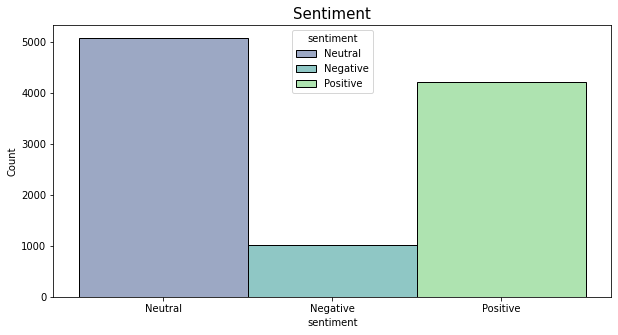

In [339]:
# menampilkan histogram untuk sentiment analisis
plt.figure(figsize=(10,5))
plt.title("Sentiment", fontsize=15)
sns.histplot(x='sentiment',hue='sentiment', palette="viridis", data=data)

In [340]:
# jumlah unique value pada analysis
data.sentiment.value_counts()

Neutral     5081
Positive    4210
Negative    1007
Name: sentiment, dtype: int64

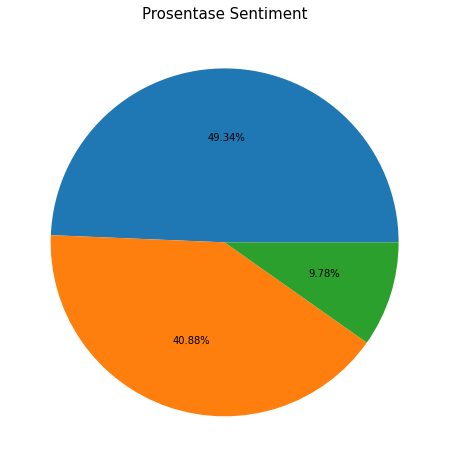

In [341]:
# menampilkan pie chart
plt.figure(figsize=(15,8))
plt.title("Prosentase Sentiment", fontsize=15)
plt.pie(data.sentiment.value_counts().sort_values(ascending=False),autopct="%.2f%%" )
plt.show()

In [342]:
# membuat kolom baru untuk mengetahui banyaknya karakter huruf yang digunakan pada text
data['total_char'] = data['tweet'].str.len()

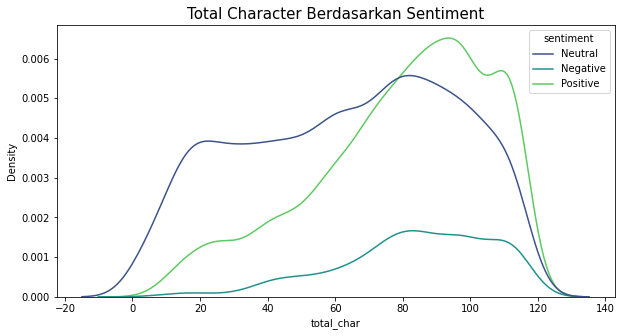

In [343]:
# menampilkan banyaknya huruf dilihat dari sentiment analisis
plt.figure(figsize=(10,5))
plt.title("Total Character Berdasarkan Sentiment", fontsize=15)
sns.kdeplot(data=data, x=data.total_char,hue=data.sentiment, palette="viridis" )

In [344]:
# mengubah waktu menjadi bulan tahun
data['date'] = data['date'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m'))

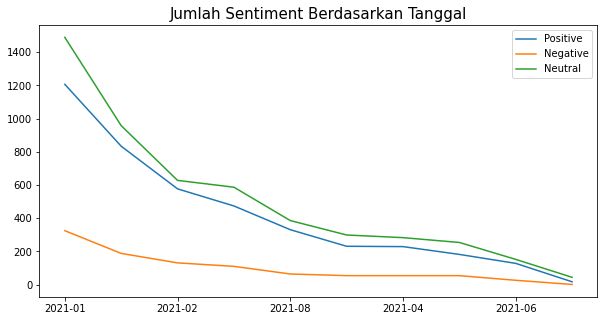

In [345]:
# plot jumlah sentiment analisis berdasarkan waktu
plt.figure(figsize=(10,5))
plt.title("Jumlah Sentiment Berdasarkan Tanggal", fontsize=15)
data[data['sentiment']=='Positive']["date"].value_counts().plot(kind='line',label='Positive')
data[data['sentiment']=='Negative']["date"].value_counts().plot(kind='line',label='Negative')
data[data['sentiment']=='Neutral']["date"].value_counts().plot(kind='line',label='Neutral')
plt.legend()

###WordCloud

In [346]:
# membuat wordcloud, disini kita dapat menampilkan banyaknya word atau kata yang sering muncul pada sebuah kalimat
from wordcloud import WordCloud

# wordcloud keseluruhan sentiment
wordcloud = WordCloud(collocations = False,
                      background_color='white',
                      max_words=200,
                      max_font_size=60,
                      random_state=42
                      ).generate(str(data['lemmatweet']))

# wordcloud sentimen positive
twt_post=data[data['sentiment']=='Positive']
wordcloud_pos = WordCloud(collocations = False,
                          background_color='white',
                          max_words=200,
                          max_font_size=60,
                          random_state=42
                          ).generate(str(twt_post['lemmatweet']))

# wordcloud sentimen negative
twt_neg= data[data['sentiment']== 'Negative']
wordcloud_neg = WordCloud(collocations = False,
                          background_color='black',
                          max_words=200,
                          max_font_size=60,
                          random_state=42
                          ).generate(str(twt_neg['lemmatweet']))

# wordcloud sentimen neutral                      
twt_neu= data[data['sentiment']== 'Neutral']
wordcloud_neu = WordCloud(collocations = False,
                      background_color='grey',
                      max_words=200,
                      max_font_size=60,
                      random_state=42
                      ).generate(str(twt_neu['lemmatweet']))


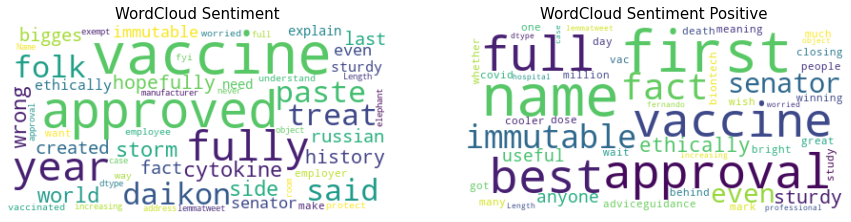

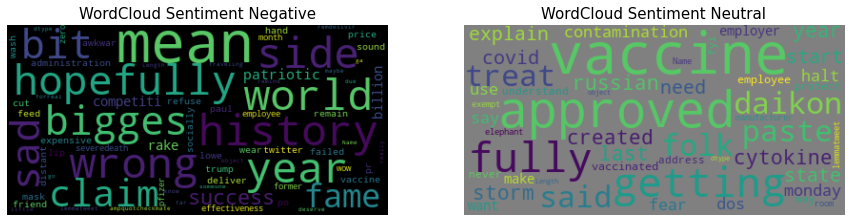

In [347]:
# plot wordcloud untuk semua sentimen yang ada

plt.figure(figsize=(15,8))
plt.subplot(121)
plt.title("WordCloud Sentiment", fontsize=15)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# plot wordcloud untuk sentimen positive
plt.subplot(122)
plt.title("WordCloud Sentiment Positive", fontsize=15)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.show()

# plot wordcloud untuk sentimen negative
plt.figure(figsize=(15,8))
plt.subplot(221)
plt.title("WordCloud Sentiment Negative", fontsize=15)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")

# plot wordcloud untuk sentimen neutral
plt.subplot(222)
plt.title("WordCloud Sentiment Neutral", fontsize=15)
plt.imshow(wordcloud_neu, interpolation='bilinear')
plt.axis("off")
plt.show()

In [348]:
from nltk.probability import FreqDist

# menghitung jumlah kata yang sering muncul pada tweet
data['word_count'] = data['tweet_token'].apply(lambda x : nltk.FreqDist(x))

In [349]:
jumlah = data['word_count'].values.sum()

In [350]:
# membuat dataframe untuk di sort 20 terbanyak
jumlah_baru = pd.DataFrame({'word':jumlah})
jumlah_baru.sort_values('word', ascending=False)[:9]

,word
vaccine,3685
dose,1422
covid,1390
first,1161
today,802
got,750
pfizer,608
get,572
second,551


<Figure size 720x360 with 0 Axes>

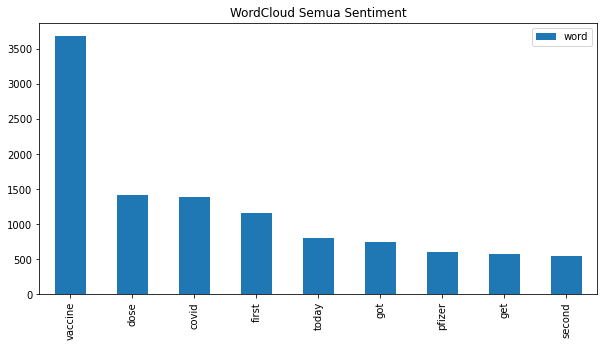

In [351]:
# menampilkan semua sentimen dari kata kata yang sering muncul

plt.figure(figsize=(10,5))
jumlah_baru.sort_values('word', ascending=False)[:9].plot(y='word', kind='bar',figsize=(10,5), title="WordCloud Semua Sentiment")

* dalam tahapan EDA dilakukan perhitungan polaritas dengan menggunakan library textblob dimana nantinya nilai yang dihasilkan dari kalimat atau tweet yang ada dapat dibuat atau diubah kedalam sentimen yang terbagi menjadi positive negative dan neutral.
* nilai polaritas didefinisikana ke Positive lebih dari 0, Negative kurang dari 0, dan Neutral sama dengan 0.
* setelah mendapatkan sentimen kemudian dilakukan plot figure untuk mendapatkan nilai dari sentimen yang ada dimana neutral merupakan sentimen dengan jumlah tertinggi dan negative merupakan jumlah sentiment terendah. 5081,4210, dan 1007. prosentasi menunjukan pembagian 49.34%,40.88%,9.78%.
* tahapan selanjutnya adalah mendapatkan karakter dari tweet yang ada dimana neutral berbentuk binomial sehingga terdapat banyak jumlah karakter di beberapa sisi. untuk positive kecenderungan membentuk leftskewed negative dimana nilainya kebanyakan disebelah kanan. dan untuk negative kurva yang muncul merupakan binomial juga.
*  jumlah banyaknya tweet dapat dilihat bahwa seiring berjalannya waktu jumlah tweet yang berkaitan dengan vaksin mengalami penurunan dan penurunan terjadi pada semua sentimen.
* pada WordCloud semua sentiment dapat dilihat bahwa banyaknya kata yang sering muncul adalah vaccine, di ikuti oleh dose, covid dan seterusnya sampai ke kata yang paling sedikit muncul.

###split data


In [352]:
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM,GlobalMaxPool1D
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l2

In [353]:
# copy data
tweet_model=data.copy()

In [354]:
# melihat ukuran vocabulary
vocabulary = set()

for tweet in tweet_model.tweet_token:
    for word in tweet:
        if word not in vocabulary:
            vocabulary.add(word)

vocab_length = len(vocabulary)

In [355]:
# jumlah vocabulary
print("banyaknya vocab:",len(vocabulary))

banyaknya vocab: 9506


In [356]:
#  menampilkan vocabulary
print(vocabulary)

{'depending', 'kati', 'refle', 'recommending', 'labeled', 'bent', 'makeup', 'russia', 'personally', 'jam', 'commit', 'gentle', 'run', 'eac', 'naas', 'ursula', 'friday', 'paste', 'fyi', 'crossed', 'euas', 'tightly', 'slam', 'privile', 'qsq', 'suspicious', 'gots', 'country', 'preordered', 'import', 'imagined', 'jonathan', 'toothpaste', 'rosdy', 'pole', 'reminds', 'sanction', 'shipm', 'revise', 'sanofi', 'anticoagulation', 'newspaper', 'hair', 'programkudos', 'hurdle', 'positive', 'season', 'opted', 'tackle', 'dire', 'backfire', 'career', 'conglomerate', 'injecti', 'relative', 'roopchand', 'fame', 'accomplishment', 'family', 'hella', 'afte', 'represents', 'whe', 'arn', 'tequila', 'tower', 'ambitio', 'diary', 'gett', 'jeopardized', 'referencias', 'enables', 'planet', 'wooooohooooo', 'go', 'felling', 'operational', 'talabani', 'rochester', 'harder', 'commitment', 'shame', 'enrolled', 'personal', 'reveals', 'profiting', 'vacci', 'filing', 'twittervers', 'demonstrates', 'john', 'examined', 'w

In [357]:
# menghitung maksimal jarak sequence
max_seq_length = 0
for tweet in tweet_model.tweet_token:
    if len(tweet) > max_seq_length:
        max_seq_length = len(tweet)

In [358]:
# menampilkan panjang kalimat
print("maximal sequence :", max_seq_length)

maximal sequence : 17


In [359]:
# membuat fungsi tokenize padding dan sequence pada object
def pipeline(test):
    tokenizer = Tokenizer(num_words=vocab_length)
    tokenizer.fit_on_texts(test)
    sequences = tokenizer.texts_to_sequences(test)
    result = pad_sequences(sequences, maxlen=max_seq_length, padding='post')
    return result

In [360]:
# mengaplikasikan pipeline
transform = pipeline(tweet_model.tweet_token)

In [361]:
# hasil pipeline
print(transform.shape)
transform

(10298, 17)


array([[ 673,   68, 4371, ...,    0,    0,    0],
       [  62,  788,   30, ...,    0,    0,    0],
       [1279,    1, 1010, ...,    0,    0,    0],
       ...,
       [ 138,  723,   46, ...,    0,    0,    0],
       [ 865, 2878,   50, ...,    0,    0,    0],
       [ 318, 2370, 3324, ...,    0,    0,    0]], dtype=int32)

In [362]:
# melakukan label encoder pada target string atau disini adlah target
from sklearn.preprocessing import LabelEncoder 

le = LabelEncoder()
label = le.fit_transform(tweet_model.sentiment)

In [363]:
# konversi ke kategorikal masing masing
from keras.utils.np_utils import to_categorical

label = to_categorical(label)
label[:2]

array([[0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [364]:
# train test split dengan X adalah transform dan y adalah label
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(transform, label, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=2/9, random_state=42)

In [365]:
# hasil split pada x train
print(X_train.shape)
X_train[:2]

(6407, 17)


array([[  67,   68,  499,  229,    7, 2581,  346, 1091,  551,    3,    0,
           0,    0,    0,    0,    0,    0],
       [  57,  335, 4189,   36,  714,   91,  131,  144,  278,  705,  927,
          89,  108,  246,    0,    0,    0]], dtype=int32)

In [366]:
# hasil split pada x train
print(y_train.shape) # setelah diubah dimensi y menjadi 2
y_train[:3]

(6407, 3)


array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

* menentukan jumlah vocabulary dari kalimat yang ada untuk diugunakan sebagai dimensi pada model nantinya, dan didapatkan sebanyak 9506.
* maximal length dicari untuk menentukan seberapa jarak yang akan digunakan atau feature dimana ditemukan sebanyak 17.
* tokenaizer digunakan untuk di fit ke object dimana objectnya adalah tweet_token yang kemudian akan dilakukan text to sequece untuk menjadikan nilai kalimat yang sudah ditokenizer dan selanjutnya dilakuakn padding sengan maksimal panjangnya 17 feature dan nilai nol akan di hitung di akhir dari fungsi padd post.
* Kemudian dilakukan label encoder untuk target yang masih berbentuk string ke integer dan kemudian di fit ke kategorikal.
* hasil object dan target kemudian di split ke train test dan val untuk digunakan pada model dimana digunakan prorporsi 2/9 dari jumlah sisa yang ada.

#Model and Training

In [367]:
# clear sesi modeling
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [368]:
# model keras sequental
model1 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=vocab_length , output_dim=32,input_length=max_seq_length),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dropout(0.15),
    keras.layers.LSTM(25,activation="tanh",
    recurrent_activation="sigmoid",
    use_bias=True,
    kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros"),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(3, activation='softmax')
])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
model1.summary()
# keras.utils.plot_model(model1, "tweet.png", show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 17, 32)            304192    
_________________________________________________________________
dropout (Dropout)            (None, 17, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 17, 20)            660       
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 20)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 25)                4600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 7

In [369]:
# model compile
model1.compile(loss='categorical_crossentropy', 
               optimizer='adamax', 
               metrics=['accuracy'])

In [370]:
# model fit
history1 = model1.fit(X_train, y_train, batch_size=10, epochs=100, validation_data=(X_val, y_val), callbacks=[es])

Epoch 1/100
641/641 [==============================] - 7s 8ms/step - loss: 0.9438 - accuracy: 0.4793 - val_loss: 0.9282 - val_accuracy: 0.4937
Epoch 2/100
641/641 [==============================] - 5s 8ms/step - loss: 0.8737 - accuracy: 0.5736 - val_loss: 0.7970 - val_accuracy: 0.6559
Epoch 3/100
641/641 [==============================] - 5s 7ms/step - loss: 0.7124 - accuracy: 0.7063 - val_loss: 0.6448 - val_accuracy: 0.7335
Epoch 4/100
641/641 [==============================] - 5s 8ms/step - loss: 0.6028 - accuracy: 0.7690 - val_loss: 0.5975 - val_accuracy: 0.7641
Epoch 5/100
641/641 [==============================] - 5s 8ms/step - loss: 0.5529 - accuracy: 0.7934 - val_loss: 0.5516 - val_accuracy: 0.7875
Epoch 6/100
641/641 [==============================] - 5s 7ms/step - loss: 0.4955 - accuracy: 0.8172 - val_loss: 0.5443 - val_accuracy: 0.7946
Epoch 7/100
641/641 [==============================] - 5s 8ms/step - loss: 0.4609 - accuracy: 0.8282 - val_loss: 0.5095 - val_accuracy: 0.8116

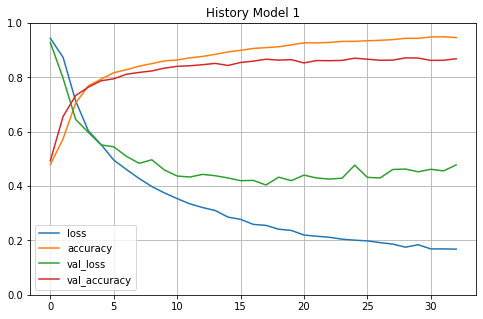

In [371]:
# menampilkan history model sequential
hist1=pd.DataFrame(history1.history)
hist1.plot(figsize=(8, 5))
plt.title("History Model 1")
plt.grid(True)
plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
plt.show()

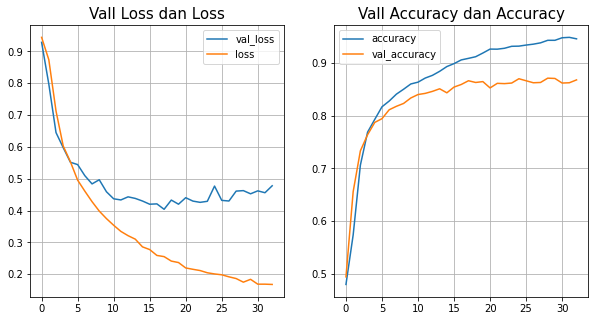

In [372]:
plt.subplot(121)
plt.gca()
plt.title('Vall Loss dan Loss', fontsize=15)
hist1['val_loss'].plot(figsize=(10, 5))
hist1['loss'].plot(figsize=(10, 5))
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.gca()
plt.title('Vall Accuracy dan Accuracy', fontsize=15)
hist1['accuracy'].plot(figsize=(10, 5))
hist1['val_accuracy'].plot(figsize=(10, 5))
plt.legend()
plt.grid(True)

In [373]:
# model evaluasi
print(model1.evaluate(X_train, y_train))
print(model1.evaluate(X_test, y_test))

201/201 [==============================] - 0s 2ms/step - loss: 0.1232 - accuracy: 0.9680
[0.12323357164859772, 0.9680037498474121]
65/65 [==============================] - 0s 2ms/step - loss: 0.5203 - accuracy: 0.8617
[0.5203012228012085, 0.8616504669189453]


* pada model digunakan input dimensi berdasarkan vocabulary dan imput length berdasarkan maksimal length yang ada.
* pada model dilakukan dropout guna mencegah terjadinya overfitting.
* aktivasi yang digunakan adlah relu dan tanh.
* layer model adalah 3 adalah karena jumlah class adalah 3. 
* earlystopping digunakan untuk meningkatkan efisiensi model sehingga ketika mendapatkan hasil optimal atau hasil yang sudah sesuai maka proses akan berhenti.
* pada model compile dipilih categorical crossentropy karena menyesuaikan bahwa class terdapt lebih dari 2.
* plot history digunakna untuk melihat history model yang berjalan sehingga mempermudah memahami model yang dihasilkan.
* model evaluate kemudian diguanakn menggunakan data test untuk mengetahui hasil model dengan test yang ada apakah bagus atau tidak.

# GridSearchCV

In [374]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
# melakukan gridsearchcv model kerasclassifier

def create_model(activation='relu',optimizer='adam'):
  model2 = Sequential()
  model2.add(keras.layers.Embedding(input_dim=vocab_length , output_dim=32,input_length=max_seq_length))
  model2.add(keras.layers.Dropout(0.15))
  model2.add(keras.layers.Dense(20, activation="relu"))
  model2.add(keras.layers.Dropout(0.15))
  model2.add(keras.layers.LSTM(25,activation=activation,
    recurrent_activation="sigmoid",
    use_bias=True,
    kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros"))
  model2.add(keras.layers.Dropout(0.15))
  model2.add(keras.layers.Dense(3, activation='softmax'))
  
 # melakukan penggabungan model 
  model2.compile(loss='categorical_crossentropy', 
               optimizer='adamax', 
               metrics=['accuracy'])
  return model2

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
  
# model kerasclassifier
model_keras = KerasClassifier(build_fn=create_model, verbose=0)

# membuat parameters
optimizer = ['Adam', 'Adamax']
activation = ['relu','tanh']
param_grid = dict(optimizer=optimizer, activation=activation)
grid = GridSearchCV(estimator=model_keras, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)


In [375]:
print('hasil parameter dari gridsearchcv :', grid_result.best_params_)

hasil parameter dari gridsearchcv : {'activation': 'relu', 'optimizer': 'Adam'}


In [376]:
model_Grid = grid.best_estimator_.model
model_Grid.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 17, 32)            304192    
_________________________________________________________________
dropout (Dropout)            (None, 17, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 17, 20)            660       
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 20)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 25)                4600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 7

In [377]:
historyGrid = model_Grid.fit(X_train, y_train, batch_size=10, epochs=50, validation_data=(X_val, y_val), callbacks=[es])

Epoch 1/50
641/641 [==============================] - 5s 8ms/step - loss: 0.9162 - accuracy: 0.5013 - val_loss: 0.8965 - val_accuracy: 0.5254
Epoch 2/50
641/641 [==============================] - 5s 7ms/step - loss: 0.8900 - accuracy: 0.5492 - val_loss: 0.8641 - val_accuracy: 0.5937
Epoch 3/50
641/641 [==============================] - 5s 7ms/step - loss: 0.8373 - accuracy: 0.6032 - val_loss: 0.7943 - val_accuracy: 0.6636
Epoch 4/50
641/641 [==============================] - 5s 7ms/step - loss: 0.7147 - accuracy: 0.7117 - val_loss: 0.6583 - val_accuracy: 0.7482
Epoch 5/50
641/641 [==============================] - 5s 7ms/step - loss: 0.5693 - accuracy: 0.7874 - val_loss: 0.5622 - val_accuracy: 0.7772
Epoch 6/50
641/641 [==============================] - 5s 7ms/step - loss: 0.5107 - accuracy: 0.8138 - val_loss: 0.5633 - val_accuracy: 0.7974
Epoch 7/50
641/641 [==============================] - 5s 7ms/step - loss: 0.4690 - accuracy: 0.8299 - val_loss: 0.5236 - val_accuracy: 0.8116
Epoch 

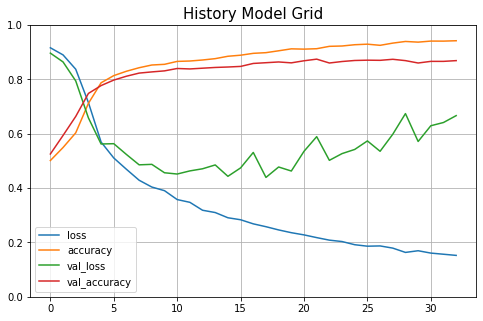

In [378]:
# menampilkan history model sequential improvement
histGrid=pd.DataFrame(historyGrid.history)
histGrid.plot(figsize=(8, 5))
plt.title("History Model Grid", fontsize=15)
plt.grid(True)
plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
plt.show()

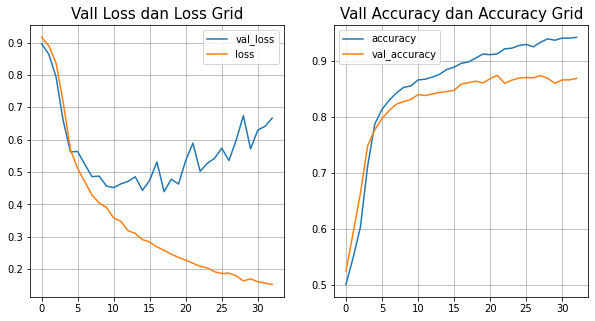

In [379]:
#menampilkan loss dan akurasi pada figure terpisah
plt.subplot(121)
plt.gca()
plt.title('Vall Loss dan Loss Grid', fontsize=15)
histGrid['val_loss'].plot(figsize=(10, 5))
histGrid['loss'].plot(figsize=(10, 5))
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.gca()
plt.title('Vall Accuracy dan Accuracy Grid', fontsize=15)
histGrid['accuracy'].plot(figsize=(10, 5))
histGrid['val_accuracy'].plot(figsize=(10, 5))
plt.legend()
plt.grid(True)

In [380]:
# model evaluasi
print(model_Grid.evaluate(X_train, y_train))
print(model_Grid.evaluate(X_test, y_test))

201/201 [==============================] - 0s 2ms/step - loss: 0.1037 - accuracy: 0.9621
[0.1037297397851944, 0.9620727300643921]
65/65 [==============================] - 0s 3ms/step - loss: 0.6658 - accuracy: 0.8646
[0.665839433670044, 0.8645631074905396]


In [381]:
# model prediction
pred = model1.predict(X_test)
y_test_1 = []
y_pred_1 = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1.append(one_hot_index)

for i in range(0, len(pred)):
    probs = pred[i]
    predicted_index = np.argmax(probs)
    y_pred_1.append(predicted_index)


pred2 = model_Grid.predict(X_test)

y_test_2 = []
y_pred_2 = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_2.append(one_hot_index)

for i in range(0, len(pred2)):
    probs = pred2[i]
    predicted_index = np.argmax(probs)
    y_pred_2.append(predicted_index)

              precision    recall  f1-score   support

    Negative       0.42      0.48      0.45       203
     Neutral       0.90      0.88      0.89       969
    Positive       0.94      0.93      0.93       888

    accuracy                           0.86      2060
   macro avg       0.75      0.76      0.76      2060
weighted avg       0.87      0.86      0.86      2060

              precision    recall  f1-score   support

    Negative       0.45      0.53      0.49       203
     Neutral       0.92      0.88      0.90       969
    Positive       0.92      0.93      0.92       888

    accuracy                           0.86      2060
   macro avg       0.76      0.78      0.77      2060
weighted avg       0.87      0.86      0.87      2060



Text(69.0, 0.5, 'Actual')

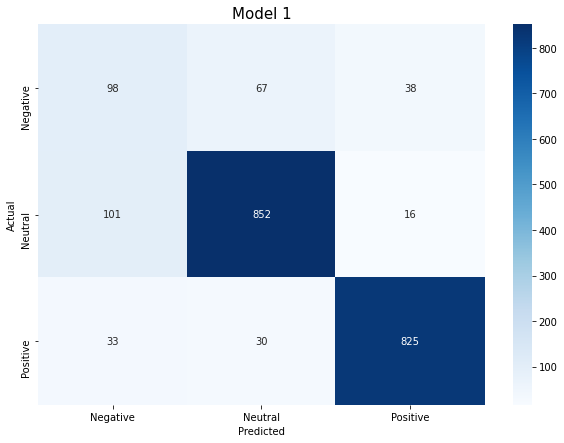

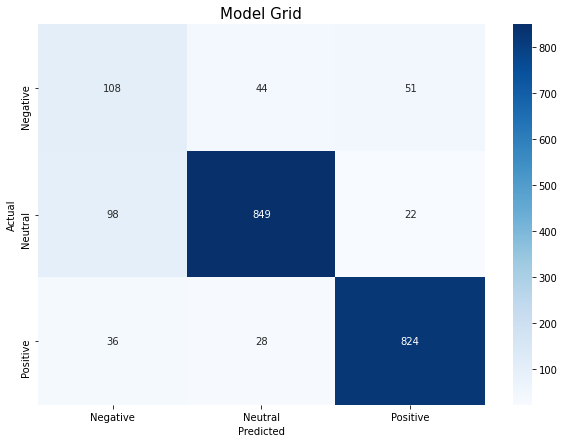

In [382]:
from sklearn.metrics import confusion_matrix, classification_report
cm = tf.math.confusion_matrix(labels=y_test_1,predictions=y_pred_1)
labels = le.classes_

print(classification_report(y_test_1,y_pred_1, target_names = labels))
plt.figure(figsize =(10,7))
plt.title('Model 1', fontsize=15)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels,cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")

print('='*50)
cm = tf.math.confusion_matrix(labels=y_test_2,predictions=y_pred_2)
labels = le.classes_

print(classification_report(y_test_2,y_pred_2, target_names = labels))
plt.figure(figsize =(10,7))
plt.title('Model Grid', fontsize=15)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels,cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")

* gridsearchcv digunakan untuk mendapatkan apakan kita dapat mendapat hasil maksimal dari model sebelumnya jika parameter tertentu kita udah dengan parameter yang lainnya. disini dapat dikatakn bahwa model grid yang dihasilkan lebih baik dibanding model1. pada classification report menunjukan bahwa model grid lebih bagus dimana nilai recall untuk negative dan f1 score lebih tinggi dibanding model1.

#Model Inference

In [383]:
tweet = {"It amazes me that the same people who accept the scientific process that led to the development of #ivermectin reject the same process that led to the #vaccine. It's almost as if their beliefs aren't based on science at all.",
          
          "Making an even stronger case for #vaccine is this study that teases a potential positive effect of the MMR and Tdap vaccination to strengthen #COVID19 protection ",
          
         "while the world has been on the wrong side of history this year hopefully the biggest vaccination effort we have"}

In [384]:
hasil = pipeline(tweet)
hasil

array([[19,  2, 20, 21, 22, 23, 24,  3,  1, 25, 26, 27,  7,  4, 28, 29,
        30],
       [33, 34,  8,  1, 35, 36,  3, 37,  6, 38, 39,  1, 40,  7, 41, 42,
        43],
       [ 2, 11,  4,  1,  5, 54, 55, 56, 57, 58, 59, 60, 61,  8, 62, 63,
        64]], dtype=int32)

In [385]:
predict = model_Grid.predict(hasil)
print(labels[np.argmax(predict,axis=1)])

['Positive' 'Positive' 'Positive']


hasil model inference menunjukan bahwa nilai model berhasil menebak data baru yang diberikan dengan nilai yang sudah ada diata.

> perlu dipahami bahwa:
1. perlu dilakukan normalisasi kata atau karakter yang belum teridentifikasi untuk meningkatkan kemampuan dalam memahami class yang dihasilkan.
2. perlu ditambahkan vocabulary untuk menambah dictionary pada model sehingga pemahaman pada kata lebih akurat.
3. parameter yang digunakan dapat di ubah dan sebagainya atupun dengan mengubah arsitektur pada model untuk optimalisasi model.
4. meningkatkan jumlah sentiment negative agar tidak terjadi bias pada hasil yang didapat.